In [1]:
import pandas as pd
from pandas import DataFrame, Series
#false positive warnings all the time:
pd.options.mode.chained_assignment = None

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import statistics

import os.path

In [2]:
#http://matplotlib.org/1.4.0/users/customizing.html

plt.style.use('ggplot')

mpl.rcParams['font.size'] = 18

### LINES
mpl.rcParams['lines.linewidth'] = '2.0'        # line width in points
mpl.rcParams['lines.marker']    = 'None'
mpl.rcParams['lines.markersize']=  '6'          # markersize, in points

###LEGEND
mpl.rcParams['legend.fontsize']='medium'

### GRIDS
mpl.rcParams['grid.color']='black'     # grid color
mpl.rcParams['grid.linestyle'] =':'    # dotted
mpl.rcParams['grid.linewidth']='0.5'   # in points
mpl.rcParams['grid.alpha']='1.0'       # transparency, between 0.0 and 1.0

### TICKS
mpl.rcParams['xtick.labelsize']="small"  # fontsize of the tick labels
mpl.rcParams['xtick.direction']="out"      # direction: in, out, or inout
mpl.rcParams['ytick.labelsize']="small"   # fontsize of the tick labels
mpl.rcParams['ytick.direction']="out"      # direction: in, out, or inout

### AXES
mpl.rcParams['axes.linewidth']  =  '1.0'    # edge linewidth
mpl.rcParams['axes.grid']       =  'True'   # display grid or not
mpl.rcParams['axes.titlesize']  =  'large'  # fontsize of the axes title
mpl.rcParams['axes.labelsize']  = 'large'  # fontsize of the x any y labels
mpl.rcParams['axes.facecolor']= 'white'     # axes background color

mpl.rcParams['figure.facecolor']= '1.0'     # figure facecolor; 0.75 is scalar gray

In [3]:
def generateFilenameResultsPerQuery(bmtuple):
    fname = './resultsperquery_csv/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryresults.csv" 


def generateSimulationID(tup):
    identifier = tup[0] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + tup[3] \
            + "_" + tup[4] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra


simulation_map = {
    "Watdiv10M": "W10", "Watdiv100M": "W100", "Watdiv1000M": "W1000", "Ontoforce": "Ont"
}

def generateSimulationIDCompact(tup, pref_length=3):
    #pref_length = 3
    identifier = tup[0][:pref_length] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + simulation_map[tup[3]] \
            + "_" + str(tup[4])[:pref_length] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra

In [4]:
def getInconsistentResultQueries(tuple_list):
    dfs = [pd.read_csv(generateFilenameResultsPerQuery(bm_tuple),sep='\t') for bm_tuple in tuple_list]
    df_all = pd.concat(dfs)
    grouped =  df_all.groupby(['query_name'], as_index=False)
    df_consistent = grouped.agg({'number_of_results': pd.Series.nunique})
    df_consistent = df_consistent.rename(columns={"number_of_results": "number_of_different_results"})
    df_inconsistent = df_consistent[df_consistent['number_of_different_results'] !=1]
    
    return df_inconsistent

def reworkResultsDF(tuple_list):
    dfs = []
    
    for bm_tuple in tuple_list:
        df = pd.read_csv(generateFilenameResultsPerQuery(bm_tuple),sep='\t')
        df = df.rename(columns={'number_of_results': generateSimulationIDCompact(bm_tuple)})
        df.drop('sim_id', axis=1, inplace=True)    
        dfs.append(df)
    
    df_combined = None
    
    for df in dfs:
        if df_combined is None:
            df_combined = df
        else:
            df_combined = pd.merge(df_combined, df, how='outer', on='query_name')
    return df_combined

# 1. Create a consensus DataFrame: number of results per query

* we start from *query_results.csv since we already observed that between threads the results are always consistent

***REMARK (warmup threads x mixsize + stress threads x mixsize:*** 
    





## A. (NoSQL,*,*,Ontoforce,Optimized)     => #query events = 1 x 1,223 + 5 x 1,223

### Tryout: Reuse functionality from 09_IntersimQueryCorrectness


* We already now that  ('Virtuoso', 1, 32,'Ontoforce', 'Optimized', '' ) is incorrect, also the multinode simulations cannot be fully trusted => generate consensus here 

In [5]:
tuple_list = [('Blazegraph', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('GraphDB', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('ES', 1, 64,'Ontoforce', 'Default', ''), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', 'VWall'), \
    ('Virtuoso', 1, 32,'Ontoforce', 'Optimized', 'VWall'),
             ] 

In [6]:
df_inc = getInconsistentResultQueries(tuple_list)
df_combined = reworkResultsDF(tuple_list)
df_inconsistent = pd.merge(df_inc, df_combined, how='inner', on='query_name')
df_inconsistent.head(n=20)

,query_name,number_of_different_results,Bla_N1_64_Ont_Opt,Gra_N1_64_Ont_Opt,ES_N1_64_Ont_Def,Vir_N1_64_Ont_Opt,Vir_N1_64_Ont_Opt_VWall,Vir_N1_32_Ont_Opt_VWall
0,queries/xdb,2,NaN,15.0,NaN,0.0,0.0,0.0
1,queries/xlf,2,NaN,1.0,1.0,0.0,0.0,0.0
2,queries/xmf,2,NaN,1.0,NaN,0.0,0.0,0.0
3,queries/xoi,2,NaN,NaN,7.0,39531.0,39531.0,39531.0
4,queries/xqf,2,NaN,NaN,1512758.0,1048576.0,1048576.0,1048576.0
5,queries/xrn,2,NaN,1.0,NaN,0.0,0.0,0.0
6,queries/xvf,2,NaN,NaN,0.0,1048576.0,1048576.0,1048576.0
7,queries/xxc,2,NaN,1.0,NaN,0.0,0.0,0.0
8,queries/xzacf,2,NaN,1.0,NaN,0.0,0.0,0.0
9,queries/xzanl,2,NaN,1.0,1.0,0.0,0.0,0.0


In [7]:
df_inconsistent.shape

(12, 8)

In [8]:
query_features = './OntoforceQueryAnalysis/ontoforce_query_features.tsv'
df_queryfeatures = pd.read_csv(query_features, sep='\t', index_col=0)

In [9]:
df_queryfeatures_counts = df_queryfeatures[['aggregation_count']]
df_queryfeatures_counts.head(n=3)

,aggregation_count
xaa,1.0
xab,1.0
xac,0.0


In [10]:
df_combined.index = df_combined['query_name'].apply(lambda n: n[8:]).values

In [11]:
df_combined.drop('query_name', axis=1, inplace=True)

In [12]:
df_combined.head(n=6)

,Bla_N1_64_Ont_Opt,Gra_N1_64_Ont_Opt,ES_N1_64_Ont_Def,Vir_N1_64_Ont_Opt,Vir_N1_64_Ont_Opt_VWall,Vir_N1_32_Ont_Opt_VWall
xar,1.0,1.0,1.0,1.0,1.0,1.0
xdm,0.0,0.0,0.0,0.0,0.0,0.0
xdq,1.0,1.0,1.0,1.0,1.0,1.0
xfu,1.0,1.0,1.0,1.0,1.0,1.0
xfx,1.0,1.0,1.0,1.0,1.0,1.0
xht,0.0,NaN,NaN,0.0,0.0,0.0


* We need a more advanced view on consistency:
    - if no engine finds results => result is a random number, UNKNOWN
    - if two different stores have the same solution: return this result
    - if the number of results is inconsistent => maximum will be correct (OLD)
    - if only one store has a result:
        - if it's a count query: the number of results is 1? (this doesn't seem to hold, depends on where the count is in the query, if in subquery result might still be 0!)
        - if it's not a count query: UNVERIFIED_VIRT for virtuoso store, UNVERIFIED_OTHER if not virtuoso


In [13]:
def stores_with_solution(row):
    stores = set()
    for k,v in zip(row.keys(),row.values):
        if not pd.isnull(v):
               stores.add(k[:3])
    return stores        

#TEST
stores_with_solution(df_combined.loc['xht'])

{'Bla', 'Vir'}

In [14]:
def is_count_query(query_name):
    return df_queryfeatures_counts.loc[query_name].values[0] == 1.0

#TEST
print(is_count_query('xaa'))  
print(is_count_query('xab'))  
print(is_count_query('xac'))  

True
True
False


In [15]:
UNKNOWN = -123
UNVERIFIED_VIRT = -234
UNVERIFIED_OTHER = -345
VIRT_WRONG = -456
    
def analyse_query_results(row):
    nonnull_row_values = row.dropna().values
    #print(nonnull_row_values)
    
    if len(nonnull_row_values) == 0: #number of results is unknown
        return UNKNOWN

    
    stores_success = stores_with_solution(row)
    #print(stores_success)
    
    if len(stores_success) > 1:                 #diffent stores found an answer
        unique_nonnull_row_values = set(nonnull_row_values)
        
        if len(unique_nonnull_row_values) == 1: #consensus
            return unique_nonnull_row_values.pop()
        else:                                   #no consensus => return maximum
            return max(unique_nonnull_row_values)
            
    else:                                       #only one store found an answer
        
        if is_count_query(row.name): #count query we know the answer is >= 1 
            #(there are queries where multiple things are counted), 
            #we also already verified count queries are correct
            
            res = nonnull_row_values[0]
            
            return res if res > 0 else VIRT_WRONG
        
        else:
            store = stores_success.pop()
            if store == 'Vir':
                return UNVERIFIED_VIRT
            else:
                return UNVERIFIED_OTHER
    
    return None

In [16]:
df_combined2 = df_queryfeatures_counts.join(df_combined, how='outer')
df_combined3 = df_combined2.drop('aggregation_count', axis=1)

In [17]:
df_combined3['consensus'] = df_combined3.apply(analyse_query_results, axis=1)

In [18]:
df_combined3.to_csv('./inconsistent_queryresults/check_ontoforce_consensus.csv', index=True, sep='\t')

In [19]:
df_combined3.shape

(1223, 7)

In [20]:
analyse_query_results(df_combined.loc['xaj'])

2.0

### OBSERVATION 1: 13 queries have not been solved by any engine => consensus result is unknown

In [21]:
mask = df_combined3['consensus'] == UNKNOWN
df_combined3[mask].shape

(13, 7)

In [22]:
df_combined3[mask].head(n=30)

,Bla_N1_64_Ont_Opt,Gra_N1_64_Ont_Opt,ES_N1_64_Ont_Def,Vir_N1_64_Ont_Opt,Vir_N1_64_Ont_Opt_VWall,Vir_N1_32_Ont_Opt_VWall,consensus
xbp,NaN,NaN,NaN,NaN,NaN,NaN,-123.0
xbr,NaN,NaN,NaN,NaN,NaN,NaN,-123.0
xcr,NaN,NaN,NaN,NaN,NaN,NaN,-123.0
xel,NaN,NaN,NaN,NaN,NaN,NaN,-123.0
xmd,NaN,NaN,NaN,NaN,NaN,NaN,-123.0
xuh,NaN,NaN,NaN,NaN,NaN,NaN,-123.0
xyy,NaN,NaN,NaN,NaN,NaN,NaN,-123.0
xzabk,NaN,NaN,NaN,NaN,NaN,NaN,-123.0
xzadf,NaN,NaN,NaN,NaN,NaN,NaN,-123.0
xzalc,NaN,NaN,NaN,NaN,NaN,NaN,-123.0


### is there anything special about these queries?

#### YES, most of them contain property path path operator * and long FILTER INs are also common

- ** xbp ** uses multiple property path (*) operators! Also a union of a number of huge FILTER IN queries 
```
?child_val <http://ns.ontoforce.com/ontologies/uncategorized/functionSubclassOf>* ?val . 
```

- ** xbr ** similar to xbp: long FILTER IN and (*) operator

- ** xcr ** no long FILTER IN but again 2 (*) operators

- ** xel ** long FILTER IN

- ** xmd ** no long FILTER IN but again 2 (*) operators

- ** xuh ** long FILTER IN and (*) operator

- ** xyy ** no long FILTER IN but again 2 (*) operators

- ** xzabk ** long FILTER IN

- ** xzadf ** long FILTER IN

- ** xzalc ** long FILTER IN

- ** xzamq ** no long FILTER IN but again 2 (*) operators

- ** xzapx ** no long FILTER IN but again 2 (*) operators

- ** xzaqc ** no long FILTER IN but again 2 (*) operators


### OBSERVATION 2: 4 queries were only solved by Virtuoso, they are probably correct but we cannot verify

In [23]:
mask = df_combined3['consensus'] == UNVERIFIED_VIRT
df_combined3[mask].shape

(4, 7)

In [24]:
df_combined3[mask]

,Bla_N1_64_Ont_Opt,Gra_N1_64_Ont_Opt,ES_N1_64_Ont_Def,Vir_N1_64_Ont_Opt,Vir_N1_64_Ont_Opt_VWall,Vir_N1_32_Ont_Opt_VWall,consensus
xmq,NaN,NaN,NaN,1.0,1.0,1.0,-234.0
xtq,NaN,NaN,NaN,0.0,0.0,0.0,-234.0
xxz,NaN,NaN,NaN,20.0,20.0,20.0,-234.0
xzaon,NaN,NaN,NaN,20.0,20.0,20.0,-234.0


### OBSERVATION 3: 0 queries were solved by an engine but NOT by Virtuoso

In [25]:
mask = df_combined3['consensus'] == UNVERIFIED_OTHER
df_combined3[mask].shape

(0, 7)

### OBSERVATION 4: 15 count queries Virtuoso returned 0 results, which conflicts with the idea of a count query => most likely wrong, review these queries to verify!!

- a count operator can be nested, for example in groupby operator so the number of results can be anything

In [26]:
mask = df_combined3['consensus'] == VIRT_WRONG
df_combined3[mask].shape

(15, 7)

In [27]:
df_wrong = df_combined3[mask]

In [28]:
df_wrong_features = df_wrong.join(df_queryfeatures)
df_wrong_features[df_wrong_features.columns[5:]]

,Vir_N1_32_Ont_Opt_VWall,consensus,order,filter_in,limit,distinct,triplePattern,tp_?po,union,tp_?p?,...,graph,optional,keys,filter,tp_???,group,query,jsonLines,jsonSize,depth
xaf,0.0,-456.0,1.0,2.0,1.0,1.0,15.0,0.0,1.0,9.0,...,0.0,2.0,61.0,13.0,6.0,0.0,4.0,366.0,12468.0,6.0
xbd,0.0,-456.0,1.0,2.0,1.0,1.0,9.0,0.0,1.0,7.0,...,0.0,2.0,45.0,5.0,2.0,0.0,4.0,248.0,8192.0,6.0
xdp,0.0,-456.0,1.0,2.0,1.0,1.0,12.0,0.0,1.0,8.0,...,0.0,2.0,53.0,9.0,4.0,0.0,4.0,307.0,10328.0,6.0
xga,0.0,-456.0,1.0,2.0,1.0,1.0,24.0,0.0,3.0,14.0,...,0.0,4.0,115.0,24.0,10.0,4.0,4.0,627.0,22220.0,7.0
xgd,0.0,-456.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,4.0,...,0.0,1.0,38.0,7.0,0.0,0.0,3.0,210.0,5314.0,5.0
xjy,0.0,-456.0,1.0,2.0,1.0,1.0,24.0,0.0,3.0,14.0,...,0.0,4.0,115.0,24.0,10.0,4.0,4.0,627.0,22214.0,7.0
xqd,0.0,-456.0,1.0,2.0,1.0,1.0,21.0,0.0,3.0,13.0,...,0.0,4.0,107.0,20.0,8.0,4.0,4.0,568.0,20100.0,7.0
xse,0.0,-456.0,1.0,2.0,1.0,1.0,18.0,0.0,3.0,12.0,...,0.0,4.0,89.0,16.0,6.0,2.0,4.0,484.0,16764.0,7.0
xzagf,0.0,-456.0,1.0,2.0,1.0,1.0,18.0,0.0,3.0,12.0,...,0.0,4.0,89.0,16.0,6.0,2.0,4.0,484.0,16756.0,7.0
xzaml,0.0,-456.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,4.0,...,0.0,1.0,38.0,7.0,0.0,0.0,3.0,210.0,5314.0,5.0


### If the count is in a subquery it is in fact possible that there are 0 results! 

**1. xaf => 0 is possible** 
```
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX  dc: <http://purl.org/dc/elements/1.1/> 
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX  dcterms: <http://purl.org/dc/terms/> 

SELECT ?val (coalesce(?label, ?val) AS ?val_label) ?vc WHERE { 
    {
        SELECT ?val (COUNT(DISTINCT ?id) as ?vc) WHERE {
            {
                SELECT ?original ?id ?val WHERE {
                    ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    ?original_1 <http://ns.ontoforce.com/ontologies/drugchemical/group> ?val. 
                    ?original_2 ?facet_source_1 ?facet_value_1. 
                    FILTER(?facet_source_1 = <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>) 
                    FILTER (?facet_value_1 IN  (...)) 
                    ?original_3 ?facet_source_2 ?facet_value_2.
                    FILTER(?facet_source_2 = ...) 
                    FILTER(?facet_value_2 = ...) 
                    ?original_4 ?facet_source_3 ?facet_value_3. 
                    FILTER(?facet_source_3 = ...) 
                    FILTER(?facet_value_3 = ...) 
                    ?original_1 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    ?original_2 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    ?original_3 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    ?original_4 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                } 
            } 
            UNION 
            { 
                SELECT ?original ?id ?val WHERE {
                    ?original <http://ns.ontoforce.com/ontologies/drugchemical/group> ?val. 
                    ?original ?facet_source_4 ?facet_value_4. 
                    FILTER(?facet_source_4 = <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>) 
                    FILTER (?facet_value_4 IN ...)) 
                    ?original ?facet_source_5 ?facet_value_5.
                    FILTER(?facet_source_5 = ...) 
                    FILTER(?facet_value_5 = ...) 
                    ?original ?facet_source_6 ?facet_value_6. 
                    FILTER(?facet_source_6 = <http://ns.ontoforce.com/ontologies/drugchemical/manufacturer>) 
                    FILTER(?facet_value_6 =...) 
                    OPTIONAL { 
                        ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    } 
                    FILTER(!BOUND(?id)) 
                } 
            } 
        } 
        GROUP BY ?val
    } 
    OPTIONAL{ 
        ?val <http://ns.ontoforce.com/2013/disqover#preferredLabel> ?label
    } 
} 
ORDER BY DESC(?vc) ?val_label 
LIMIT 18 
OFFSET 0
```

**2. xbd => 0 is possible** 
```
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX  dc: <http://purl.org/dc/elements/1.1/> 
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX  dcterms: <http://purl.org/dc/terms/> 

SELECT ?val (coalesce(?label, ?val) AS ?val_label) ?vc WHERE { 
    {
        SELECT ?val (COUNT(DISTINCT ?id) as ?vc) WHERE { 
            { 
                SELECT ?original ?id ?val WHERE { 
                    ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
                    ?original_1 <http://ns.ontoforce.com/ontologies/drugchemical/manufacturer> ?val.
                    ?original_2 ?facet_source_1 ?facet_value_1. 
                    FILTER(?facet_source_1 = ...) 
                    FILTER (?facet_value_1 IN (...)) 
                    ?original_1 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    ?original_2 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                } 
            } 
            UNION { 
                SELECT ?original ?id ?val WHERE { 
                    ?original <http://ns.ontoforce.com/ontologies/drugchemical/manufacturer> ?val. 
                    ?original ?facet_source_2 ?facet_value_2. 
                    FILTER(?facet_source_2 = ...) 
                    FILTER (?facet_value_2 IN (...)) 
                    OPTIONAL { 
                        ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    } 
                    FILTER(!BOUND(?id)) 
                } 
            } 
        } 
        GROUP BY ?val
    } 
    OPTIONAL { 
        ?val <http://ns.ontoforce.com/2013/disqover#preferredLabel> ?label
    } 
} 
ORDER BY DESC(?vc) ?val_label 
LIMIT 18 
OFFSET 0 
```

**3. xdp => 0 is possible** 
```
SELECT ?val (coalesce(?label, ?val) AS ?val_label) ?vc WHERE { 
    {
        SELECT ?val (COUNT(DISTINCT ?id) as ?vc) WHERE { 
            { 
                SELECT ?original ?id ?val WHERE {
                    ...
```

**4. xga => 0 is possible** 
```
SELECT ?val (coalesce(?label, ?val) AS ?val_label) ?vc WHERE {
    {
        SELECT ?val (COUNT(DISTINCT ?id) as ?vc) WHERE {
            { 
                SELECT ?original ?id ?val WHERE {
                    ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
                    ?original_1 <http://ns.ontoforce.com/ontologies/drugchemical/affectedOrganism> ?val.
                    ?original_2 ?facet_source_1 ?facet_value_1. 
                    FILTER(?facet_source_1 = <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>) 
                    FILTER (?facet_value_1 IN (...)) 
                    ?original_3 ?facet_source_2 ?facet_value_2. 
                    FILTER(?facet_source_2 = ...) 
                    FILTER(?facet_value_2 = ...) 
                    { 
                        OPTIONAL {
```


**5. xgd => 0 is possible** 
```
PREFIX owl: <http://www.w3.org/2002/07/owl#> PREFIX  dc: <http://purl.org/dc/elements/1.1/> 
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX  dcterms: <http://purl.org/dc/terms/> 

SELECT (?class AS ?val) (COUNT(DISTINCT ?original) AS ?vc) WHERE { 
    ?original a ?class . 
    { 
        SELECT ?original ?assoc WHERE { 
            ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?assoc.
            FILTER (!bound(?original_1)) 
            ?original_1 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?assoc.
            FILTER(!BOUND(?facet_value_2)) 
            FILTER(!BOUND(?facet_value_3)) 
        } 
    } 
    UNION { 
        SELECT ?original ?assoc WHERE {
            FILTER (!bound(?original)) 
            OPTIONAL { 
                ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?assoc. 
            } 
            FILTER(!BOUND(?assoc)) 
            FILTER(!BOUND(?facet_value_2)) 
            FILTER(!BOUND(?facet_value_3)) 
        } 
    } 
} 
GROUP BY ?class 
```

**6. xjy => 0 is possible** 
```
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX  dc: <http://purl.org/dc/elements/1.1/> 
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX  dcterms: <http://purl.org/dc/terms/> 

SELECT ?val (coalesce(?label, ?val) AS ?val_label) ?vc WHERE {
    {
        SELECT ?val (COUNT(DISTINCT ?id) as ?vc) WHERE {
            {
                SELECT ?original ?id ?val WHERE {
                    ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    ?original_1 <http://ns.ontoforce.com/ontologies/drugchemical/substanceType> ?val. 
                    ?original_2 ?facet_source_1 ?facet_value_1. 
                    FILTER(?facet_source_1 = <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>) 
                    FILTER (?facet_value_1 IN (...)) 
                    ?original_3 ?facet_source_2 ?facet_value_2. 
                    FILTER(?facet_source_2 = ...) 
                    FILTER(?facet_value_2 = <http://ns.ontoforce.com/ontologies/chembl/4>) 
                    { 
                        OPTIONAL{ 
                            ?original_4 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                            {
                                ?original_4 <http://ns.ontoforce.com/ontologies/drugchemical/group> ?facet_value_3 
                            } 
                        } 
                    } 
                    UNION { 
                        ?original_5 ?facet_source_3 ?facet_value_4. 
                        FILTER(?facet_source_3 = <http://ns.ontoforce.com/ontologies/drugchemical/group>) 
                        FILTER(?facet_value_4 = <http://ns.ontoforce.com/ontologies/drugchemical/withdrawn>) 
                    }
                    UNION { 
                        ?original_6 ?facet_source_4 ?facet_value_5. 
                        FILTER(?facet_source_4 = <http://ns.ontoforce.com/ontologies/drugchemical/group>) 
                        FILTER(?facet_value_5 = <http://ns.ontoforce.com/ontologies/drugchemical/nutraceutical>) 
                    } 
                    ?original_7 ?facet_source_5 ?facet_value_6. 
                    FILTER(?facet_source_5 = <http://ns.ontoforce.com/ontologies/drugchemical/manufacturer>) 
                    FILTER(?facet_value_6 = ...) 
                    ?original_1 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
                    ?original_2 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
                    ?original_3 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
                    ?original_5 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
                    ?original_6 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
                    ?original_7 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    FILTER(!BOUND(?facet_value_3)) 
                } 
            } 
            UNION { 
                SELECT ?original ?id ?val WHERE { 
                    ?original <http://ns.ontoforce.com/ontologies/drugchemical/substanceType> ?val.
                    ?original ?facet_source_6 ?facet_value_7.
                    FILTER(?facet_source_6 = <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>) 
                    FILTER (?facet_value_7 IN (..)) 
                    ?original ?facet_source_7 ?facet_value_8.
                    FILTER(?facet_source_7 = ..) 
                    FILTER(?facet_value_8 = <http://ns.ontoforce.com/ontologies/chembl/4>) 
                    { 
                        OPTIONAL{ 
                            { 
                                ?original <http://ns.ontoforce.com/ontologies/drugchemical/group> ?facet_value_9 
                            } 
                        } 
                    } 
                    UNION { 
                        ?original ?facet_source_8 ?facet_value_10. 
                        FILTER(?facet_source_8 = <http://ns.ontoforce.com/ontologies/drugchemical/group>) 
                        FILTER(?facet_value_10 = <http://ns.ontoforce.com/ontologies/drugchemical/withdrawn>) 
                    } 
                    UNION { 
                        ?original ?facet_source_9 ?facet_value_11. 
                        FILTER(?facet_source_9 = <http://ns.ontoforce.com/ontologies/drugchemical/group>) 
                        FILTER(?facet_value_11 = <http://ns.ontoforce.com/ontologies/drugchemical/nutraceutical>) 
                    } 
                    ?original ?facet_source_10 ?facet_value_12. 
                    FILTER(?facet_source_10 = ...) 
                    FILTER(?facet_value_12 = ...) 
                    OPTIONAL { 
                        ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
                    } 
                    FILTER(!BOUND(?id)) 
                    FILTER(!BOUND(?facet_value_3)) 
                    FILTER(!BOUND(?facet_value_9)) 
                } 
            } 
        } 
        GROUP BY ?val
    } 
    OPTIONAL { 
        ?val <http://ns.ontoforce.com/2013/disqover#preferredLabel> ?label
    } 
} 
ORDER BY DESC(?vc) ?val_label 
LIMIT 18 
OFFSET 0 
```

**7. xqd => 0 is possible** 

**8. xse => 0 is possible** 

**9. xzagf => 0 is possible** 

**10. xzaml => 0 is possible** 

**11.  xzamp  => 0 is possible** 

**12. xzams  => 0 is possible** 

**13. xzapj  => 0 is possible** 

**14. xzaux => 0 is possible** 

**15. xzavi => 0 is possible** 

### CONCLUSION: drop special label and consider Vir


In [29]:
df_combined3.loc[df_combined3['consensus'] == VIRT_WRONG, 'consensus'] = UNVERIFIED_VIRT
df_combined3

,Bla_N1_64_Ont_Opt,Gra_N1_64_Ont_Opt,ES_N1_64_Ont_Def,Vir_N1_64_Ont_Opt,Vir_N1_64_Ont_Opt_VWall,Vir_N1_32_Ont_Opt_VWall,consensus
xaa,NaN,1.0,1.0,1.0,1.0,1.0,1.0
xab,NaN,2.0,NaN,2.0,2.0,2.0,2.0
xac,NaN,1.0,1.0,1.0,1.0,1.0,1.0
xad,NaN,0.0,0.0,0.0,0.0,0.0,0.0
xae,NaN,1.0,1.0,1.0,1.0,1.0,1.0
xaf,NaN,NaN,NaN,0.0,0.0,0.0,-234.0
xag,NaN,1.0,1.0,1.0,1.0,1.0,1.0
xah,NaN,0.0,0.0,0.0,0.0,0.0,0.0
xai,NaN,1.0,1.0,1.0,1.0,1.0,1.0
xaj,NaN,NaN,NaN,2.0,2.0,2.0,2.0


### OBSERVATION 5: 1191 Queries for which we are quite certain about the result, since it was confirmed by at least a second independent store!



In [30]:
mask = df_combined3['consensus'] >=0.0
df_combined3[mask].shape

(1191, 7)

### OBSERVATION 6: 1 query with 2^20 results => ES gives 0 => ES wrong!

In [31]:
df_combined3.loc['xvf','consensus'] = UNVERIFIED_VIRT 

In [32]:
df_consensus = pd.DataFrame(df_combined3[['consensus']])
df_consensus['query_name_temp'] = list(df_consensus.index)
df_consensus['query_name'] = df_consensus['query_name_temp'].apply(lambda q: 'queries/' + q)
df_consensus.drop('query_name_temp', axis=1, inplace=True)
df_consensus.reset_index(inplace=True)
df_consensus.drop('index', axis=1, inplace=True)
df_consensus['consensus'] = pd.to_numeric(df_consensus['consensus'], downcast='integer')
df_consensus[['query_name','consensus']].to_csv('./inconsistent_queryresults/NoSQL_queryconsensus_Ontoforce.csv', sep='\t', index=False)
df_consensus[['query_name','consensus']].head(n=5)

,query_name,consensus
0,queries/xaa,1
1,queries/xab,2
2,queries/xac,1
3,queries/xad,0
4,queries/xae,1


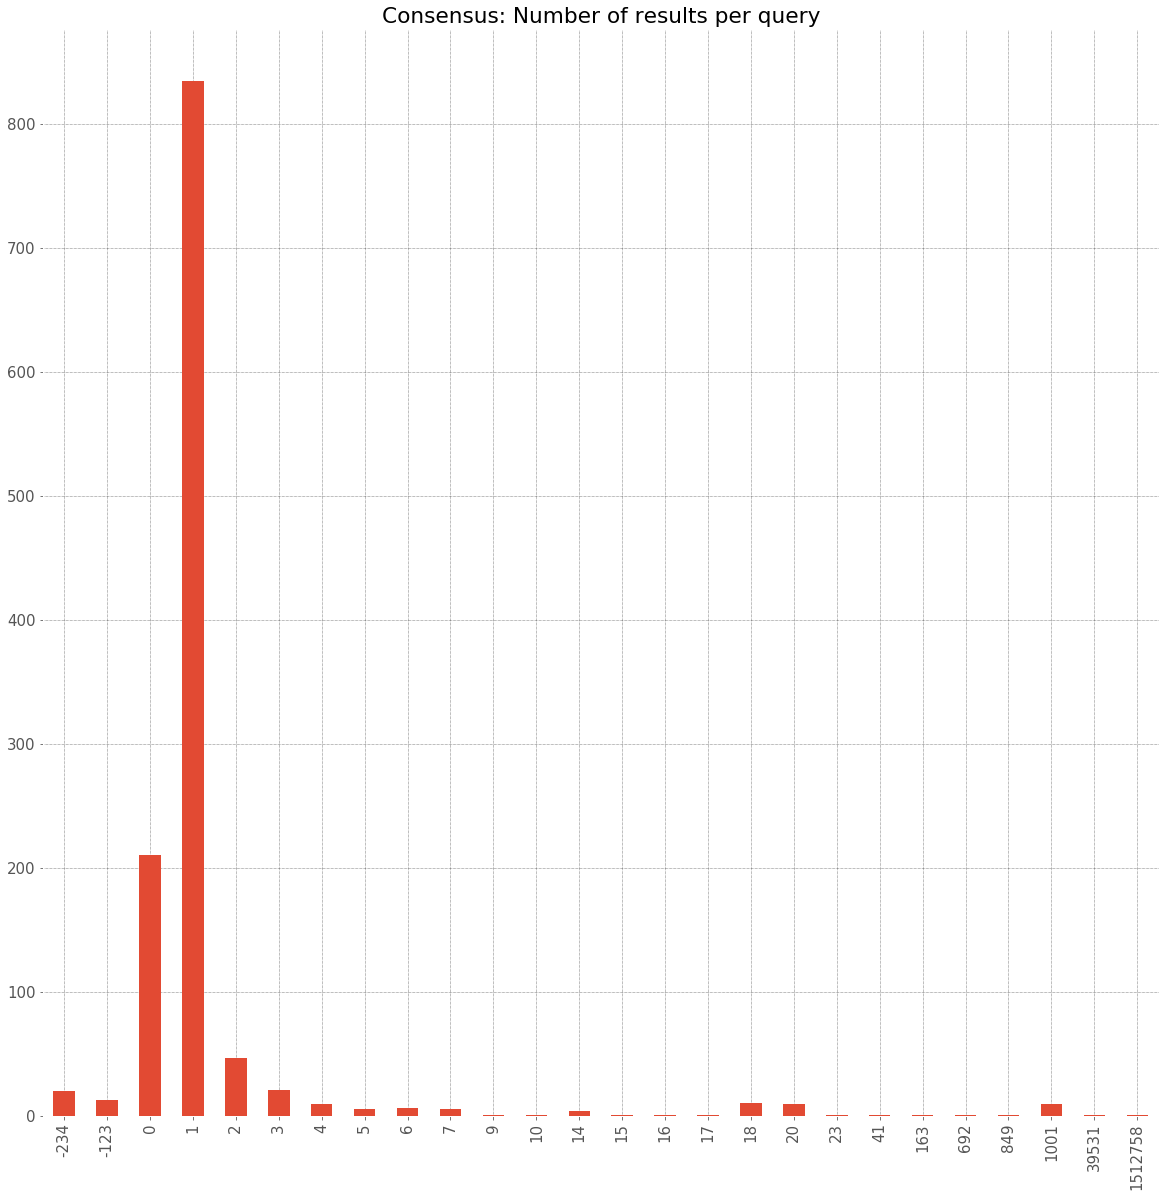

In [33]:
df_consensus['consensus'].value_counts().sort_index().plot(kind='bar', figsize=(20,20), title='Consensus: Number of results per query')

In [34]:
df_consensus['consensus'].value_counts().sort_index()

-234         20
-123         13
 0          211
 1          835
 2           47
 3           21
 4           10
 5            6
 6            7
 7            6
 9            1
 10           1
 14           4
 15           1
 16           1
 17           1
 18          11
 20          10
 23           1
 41           1
 163          1
 692          1
 849          1
 1001        10
 39531        1
 1512758      1
Name: consensus, dtype: int64

In [35]:
print('20 queries which are only solved by Virtuoso (not verified) ' + str(UNVERIFIED_VIRT))
print('13 queries which are not solved by any of the engines ' + str(UNKNOWN))

20 queries which are only solved by Virtuoso (not verified) -234
13 queries which are not solved by any of the engines -123


# 2. Create a Sim_queryevents_correct.csv 

* additional column with a status on whether the query was correct: CORRECT, INCORRECT, INCERTAIN

### Tryout

In [36]:
def generateFilenameQueryEvents(bmtuple):
    fname = './csv/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryevents.csv"

def generateFilenameQueryEventsCorrect(bmtuple):
    fname = './csv_correct/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryevents_correct.csv"

In [37]:
bm_tup = ('Blazegraph', 1, 64, 'Ontoforce', 'Optimized', '')
filename = generateFilenameQueryEvents(bm_tup)
df = pd.read_csv(filename, sep='\t')
df.head(n=5)

,sim_id,query_name,thread_id,thread_type,order_id,number_of_results,runtime,flag
0,Bla_N1_64_Ont_Opt,queries/xzaub,1,warmup,1,0,0.164710,SUCCESS
1,Bla_N1_64_Ont_Opt,queries/xdm,1,warmup,2,0,0.055763,SUCCESS
2,Bla_N1_64_Ont_Opt,queries/xzalo,1,warmup,3,1,52.323868,SUCCESS
3,Bla_N1_64_Ont_Opt,queries/xjf,1,warmup,4,-1,1200.000000,TIMEOUT
4,Bla_N1_64_Ont_Opt,queries/xyc,1,warmup,5,-1,1200.000000,TIMEOUT


In [38]:
filename_queryconsensus = './inconsistent_queryresults/NoSQL_queryconsensus_Ontoforce.csv'
df_consensus = pd.read_csv(filename_queryconsensus, sep='\t')
df_consensus.head(n=5)

,query_name,consensus
0,queries/xaa,1
1,queries/xab,2
2,queries/xac,1
3,queries/xad,0
4,queries/xae,1


In [39]:
df_consensus['consensus'].value_counts()

 1          835
 0          211
 2           47
 3           21
-234         20
-123         13
 18          11
 4           10
 20          10
 1001        10
 6            7
 5            6
 7            6
 14           4
 10           1
 9            1
 1512758      1
 15           1
 17           1
 23           1
 41           1
 163          1
 39531        1
 692          1
 849          1
 16           1
Name: consensus, dtype: int64

In [40]:
VIRT_WRONG
UNKNOWN
UNVERIFIED_OTHER
UNVERIFIED_VIRT

def assess_correctness(bmtuple, consensus):
    filename = generateFilenameQueryEvents(bmtuple)
    df = pd.read_csv(filename, sep='\t')
    df_consensus = pd.read_csv(consensus, sep='\t')
    df_correct = pd.merge(df, df_consensus, how='outer', on='query_name')
    df_correct['correct_temp']= df_correct['number_of_results'] == df_correct['consensus']
    df_correct['correct'] = df_correct['correct_temp'].apply(lambda r: 'CORRECT' if r is True else 'INCORRECT')
    
    #if number of results>=0 and UNKNOWN, UNVERIFIED => INCERTAIN
    mask1 = df_correct['number_of_results'] >=0
    mask2 = df_correct['consensus'] < 0

    df_correct.loc[mask1 & mask2, 'correct'] = 'UNCERTAIN'
    
    
    df_correct.drop(['consensus', 'correct_temp'], axis=1, inplace=True)
    #print(df_correct['correct'].value_counts())
    
    print(pd.crosstab(df_correct['correct'],df_correct['flag']))
    
    full_path = generateFilenameQueryEventsCorrect(bmtuple)
    df_correct.to_csv(full_path, sep='\t', index=False)
    print("Written to: " + str(full_path))
    return
    

In [41]:
assess_correctness(bm_tup, filename_queryconsensus)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT         36        0
INCORRECT        1      431
Written to: ./csv_correct/Blazegraph_N1_64_Ontoforce_Optimized_queryevents_correct.csv


### All Ontoforce Benchmark Runs

In [42]:
tuple_list = [('Blazegraph', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('GraphDB', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('ES', 1, 64,'Ontoforce', 'Default', ''), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('Virtuoso', 1, 32,'Ontoforce', 'Optimized', ''), \
    ('Virtuoso', 1, 32,'Ontoforce', 'Optimized', 'VWall'), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', 'VWall'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '0'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '1'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '2'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS1'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS2'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS3'), \
    ('Fuseki', 1, 64,'Ontoforce', 'Default', ''), \
    ('FluidOps', 1, 64,'Ontoforce', 'Default', '1'), \
    ('FluidOps', 1, 64,'Ontoforce', 'Default', '2'), \
    ('FluidOps', 1, 64,'Ontoforce', 'Default', '3'), \
    ('FluidOps', 3, 64,'Ontoforce', 'Default', '1'), \
    ('FluidOps', 3, 64,'Ontoforce', 'Default', '2'), \
    ('FluidOps', 3, 64,'Ontoforce', 'Default', '3')]



In [43]:
assess_correctness(tuple_list[0], filename_queryconsensus)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT         36        0
INCORRECT        1      431
Written to: ./csv_correct/Blazegraph_N1_64_Ontoforce_Optimized_queryevents_correct.csv


In [44]:
assess_correctness(tuple_list[1], filename_queryconsensus)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       1583        0
INCORRECT        0     2372
Written to: ./csv_correct/GraphDB_N1_64_Ontoforce_Optimized_queryevents_correct.csv


In [45]:
assess_correctness(tuple_list[2], filename_queryconsensus)
print("Actually the 'uncertain query' is wrong, since virtuoso gave 2^20 results, while ES 0, but since both are wrong...")

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0     4246        0
INCORRECT   1830        1     1257
UNCERTAIN      0        4        0
Written to: ./csv_correct/ES_N1_64_Ontoforce_Default_queryevents_correct.csv
Actually the 'uncertain query' is wrong, since virtuoso gave 2^20 results, while ES 0, but since both are wrong...


In [46]:
assess_correctness(tuple_list[3], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0     7069        0
INCORRECT     48       60       41
UNCERTAIN      0      120        0
Written to: ./csv_correct/Virtuoso_N1_64_Ontoforce_Optimized_queryevents_correct.csv


* Incorrect queries Virtuoso_N1_64_Ontoforce_Optimized???

In [47]:
df = pd.read_csv('./csv_correct/Virtuoso_N1_64_Ontoforce_Optimized_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results")
print('Correct result: ' + str(706900/(6*1223-120)) + " %")
print('Unreported incorrect result: ' + str(6000/(6*1223-120)) + " %")

0          54
1048576     6
Name: number_of_results, dtype: int64
Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results
Correct result: 97.93571626489332 %
Unreported incorrect result: 0.8312551953449709 %


In [48]:
assess_correctness(tuple_list[4], filename_queryconsensus)

flag       ERROR  SUCCESS
correct                  
CORRECT        0     4194
INCORRECT     48     2946
UNCERTAIN      0      150
Written to: ./csv_correct/Virtuoso_N1_32_Ontoforce_Optimized_queryevents_correct.csv


* Incorrect queries Virtuoso_N1_32_Ontoforce_Optimized??? BAD SIMULATION

In [49]:
df = pd.read_csv('./csv_correct/Virtuoso_N1_32_Ontoforce_Optimized_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 2946 queries with 0 results while consensus > 0 => simulation results are invalid!!!")
print('Correct result: ' + str(419400/(6*1223-150)) + " %")
print('Unreported incorrect result: ' + str(294600/(6*1223-120)) + " %")

0    2946
Name: number_of_results, dtype: int64
Incorrect queries are: 2946 queries with 0 results while consensus > 0 => simulation results are invalid!!!
Correct result: 58.347245409015024 %
Unreported incorrect result: 40.81463009143807 %


In [50]:
assess_correctness(tuple_list[5], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0     7072        0
INCORRECT     48       60       39
UNCERTAIN      0      119        0
Written to: ./csv_correct/Virtuoso_N1_32_Ontoforce_Optimized_VWall_queryevents_correct.csv


* Incorrect queries Virtuoso_N1_32_Ontoforce_Optimized_VWall???

In [51]:
df = pd.read_csv('./csv_correct/Virtuoso_N1_32_Ontoforce_Optimized_VWall_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results")
print('Correct result: ' + str(707200/(6*1223-119)) + " %")
print('Unreported incorrect result: ' + str(6000/(6*1223-120)) + " %")

0          54
1048576     6
Name: number_of_results, dtype: int64
Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results
Correct result: 97.96370688461006 %
Unreported incorrect result: 0.8312551953449709 %


In [52]:
assess_correctness(tuple_list[6], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0     7069        0
INCORRECT     48       60       41
UNCERTAIN      0      120        0
Written to: ./csv_correct/Virtuoso_N1_64_Ontoforce_Optimized_queryevents_correct.csv


* Incorrect queries Virtuoso_N1_64_Ontoforce_Optimized???

In [53]:
df = pd.read_csv('./csv_correct/Virtuoso_N1_64_Ontoforce_Optimized_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results")
print('Correct result: ' + str(706900/(6*1223-120)) + " %")
print('Unreported incorrect result: ' + str(6000/(6*1223-120)) + " %")

0          54
1048576     6
Name: number_of_results, dtype: int64
Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results
Correct result: 97.93571626489332 %
Unreported incorrect result: 0.8312551953449709 %


In [54]:
assess_correctness(tuple_list[7], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0     7073        0
INCORRECT     48       60       37
UNCERTAIN      0      120        0
Written to: ./csv_correct/Virtuoso_N1_64_Ontoforce_Optimized_VWall_queryevents_correct.csv


* Incorrect queries Virtuoso_N1_64_Ontoforce_Optimized_Vwall???

In [55]:
df = pd.read_csv('./csv_correct/Virtuoso_N1_64_Ontoforce_Optimized_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 54 times gives 0 results while the consensus is > 0, 6 queries with 2^20 results")
print('Correct result: ' + str(707300/(6*1223-120)) + " %")
print('Unreported incorrect result: ' + str(6000/(6*1223-120)) + " %")

0          54
1048576     6
Name: number_of_results, dtype: int64
Incorrect queries are: 54 times gives 0 results while the consensus is > 0, 6 queries with 2^20 results
Correct result: 97.99113327791632 %
Unreported incorrect result: 0.8312551953449709 %


In [56]:
assess_correctness(tuple_list[8], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0     4072        0
INCORRECT   3182       27       19
UNCERTAIN      0       38        0
Written to: ./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_0_queryevents_correct.csv


* Incorrect queries Virtuoso_N3_64_Ontoforce_Optimized_0??? Many errors but very little unreported incorrect queries => simulation can be used in analysis!

In [57]:
df = pd.read_csv('./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_0_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results")
print('Correct result: ' + str(707300/(6*1223-120)) + " %")
print('Unreported incorrect result: ' + str(2700/(6*1223-120)) + " %")

0          24
1048576     3
Name: number_of_results, dtype: int64
Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results
Correct result: 97.99113327791632 %
Unreported incorrect result: 0.3740648379052369 %


In [58]:
df_correct = df[df['correct'] == 'CORRECT']
df_correct.shape

(4072, 9)

In [59]:
mask = df_correct['thread_type'] == 'stress'
dfcorrectstress = df_correct[mask]
dfcorrectstress.shape

(2918, 9)

In [60]:
dfcs_grp = dfcorrectstress.groupby('query_name').count()

In [61]:
dfcs_grp.shape

(1122, 8)

In [62]:
assess_correctness(tuple_list[9], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0      168        0
INCORRECT   7165        0        5
Written to: ./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_1_queryevents_correct.csv


* Incorrect queries Virtuoso_N3_64_Ontoforce_Optimized_1??? Crashed too soon to be usable..

In [63]:
df = pd.read_csv('./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_1_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results")
print('Correct result: ' + str(16800/(6*1223-120)) + " %")
print('Unreported incorrect result: ' + str(0/(6*1223-120)) + " %")

Series([], Name: number_of_results, dtype: int64)
Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results
Correct result: 2.3275145469659186 %
Unreported incorrect result: 0.0 %


In [64]:
assess_correctness(tuple_list[10], filename_queryconsensus)

flag       ERROR  SUCCESS
correct                  
CORRECT        0     3918
INCORRECT    636     2718
UNCERTAIN      0       66
Written to: ./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_2_queryevents_correct.csv


* Incorrect queries Virtuoso_N3_64_Ontoforce_Optimized_2??? Problematic, many unreported incorrect queries!!

In [65]:
df = pd.read_csv('./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_2_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results")
print('Correct result: ' + str(391800/(6*1223-66)) + " %")
print('Unreported incorrect result: ' + str(271800/(6*1223-120)) + " %")

0    2718
Name: number_of_results, dtype: int64
Incorrect queries are: 54 times gives 6 results while the consensus is > 0, 6 queries with 2^20 results
Correct result: 53.87788778877888 %
Unreported incorrect result: 37.65586034912718 %


In [66]:
assess_correctness(tuple_list[11], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0      104        0
INCORRECT   7228        0        6
Written to: ./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_AWS1_queryevents_correct.csv


* Incorrect queries Virtuoso_N3_64_Optimized_AWS1 ??  None, but very little successful queries too

In [67]:
df = pd.read_csv('./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_AWS1_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("No incorrect queries")
print('Correct result: ' + str(10400/(6*1223-0)) + " %")
print('Unreported incorrect result: ' + str(0/(6*1223-120)) + " %")

Series([], Name: number_of_results, dtype: int64)
No incorrect queries
Correct result: 1.4172799127827747 %
Unreported incorrect result: 0.0 %


In [68]:
assess_correctness(tuple_list[12], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0      204        0
INCORRECT   7119        3        9
UNCERTAIN      0        3        0
Written to: ./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_AWS2_queryevents_correct.csv


* Incorrect queries Virtuoso_N3_64_Optimized_AWS1 ??  None, but very little successful queries too

In [69]:
df = pd.read_csv('./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_AWS2_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 2 times gives 0 results while the consensus is > 0, 1 query with 2^20 results")
print('Correct result: ' + str(20400/(6*1223-3)) + " %")
print('Unreported incorrect result: ' + str(300/(6*1223-3)) + " %")

0          2
1048576    1
Name: number_of_results, dtype: int64
Incorrect queries are: 2 times gives 0 results while the consensus is > 0, 1 query with 2^20 results
Correct result: 2.7811860940695294 %
Unreported incorrect result: 0.0408997955010225 %


In [70]:
assess_correctness(tuple_list[13], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0      216        0
INCORRECT    460        2        9
Written to: ./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_AWS3_queryevents_correct.csv


* Incorrect queries Virtuoso_N3_64_Optimized_AWS3 ??  Only a few, but very little successful queries too

In [71]:
df = pd.read_csv('./csv_correct/Virtuoso_N3_64_Ontoforce_Optimized_AWS3_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are: 2 times gives 0 results while the consensus is > 0")
print('Correct result: ' + str(21600/(6*1223-0)) + " %")
print('Unreported incorrect result: ' + str(200/(6*1223-0)) + " %")

0.0    2
Name: number_of_results, dtype: int64
Incorrect queries are: 2 times gives 0 results while the consensus is > 0
Correct result: 2.9435813573180702 %
Unreported incorrect result: 0.02725538293813028 %


In [72]:
assess_correctness(tuple_list[14], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0      191        0
INCORRECT    492       15     1954
Written to: ./csv_correct/Fuseki_N1_64_Ontoforce_Default_queryevents_correct.csv


* Incorrect queries Fuseki_N1_64_Ontoforce_Default ??  Only a few, but very little successful queries too

In [73]:
df = pd.read_csv('./csv_correct/Fuseki_N1_64_Ontoforce_Default_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are due to incorrect restriction based on GRAPHS => default graph was always queried")
print('Correct result: ' + str(19100/(6*1223-0)) + " %")
print('Unreported incorrect result: ' + str(15/(6*1223-0)) + " %")

0       7
1       3
143     1
20      1
2       1
146     1
1344    1
Name: number_of_results, dtype: int64
Incorrect queries are due to incorrect restriction based on GRAPHS => default graph was always queried
Correct result: 2.602889070591442 %
Unreported incorrect result: 0.002044153720359771 %


In [74]:
assess_correctness(tuple_list[15], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0     2519        0
INCORRECT     18       20       31
UNCERTAIN      0       39        0
Written to: ./csv_correct/FluidOps_N1_64_Ontoforce_Default_1_queryevents_correct.csv


* FluidOps N1: query forwarding to Virtuoso Open Source

In [75]:
print("Funny fact: By decomposing the queries, some of Virtuoso incorrect results are circumvented!!")

Funny fact: By decomposing the queries, some of Virtuoso incorrect results are circumvented!!


In [76]:
df = pd.read_csv('./csv_correct/FluidOps_N1_64_Ontoforce_Default_1_queryevents_correct.csv', sep='\t')
mask1 = df['correct'] == 'INCORRECT'
mask2 = df['flag'] == 'SUCCESS'
print(df[mask1 & mask2]['number_of_results'].value_counts())
print("Incorrect queries are due to incorrect restriction based on GRAPHS => default graph was always queried")
print('Correct result: ' + str(19100/(6*1223-0)) + " %")
print('Unreported incorrect result: ' + str(15/(6*1223-0)) + " %")

0          19
1468910     1
Name: number_of_results, dtype: int64
Incorrect queries are due to incorrect restriction based on GRAPHS => default graph was always queried
Correct result: 2.602889070591442 %
Unreported incorrect result: 0.002044153720359771 %


In [77]:
assess_correctness(tuple_list[16], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0      170        0
INCORRECT      1        1        7
UNCERTAIN      0        2        0
Written to: ./csv_correct/FluidOps_N1_64_Ontoforce_Default_2_queryevents_correct.csv


In [78]:
assess_correctness(tuple_list[17], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0     6675        0
INCORRECT     45       52      449
UNCERTAIN      0      117        0
Written to: ./csv_correct/FluidOps_N1_64_Ontoforce_Default_3_queryevents_correct.csv


In [79]:
print("Funny fact: By decomposing the queries, some of Virtuoso incorrect results are circumvented!!")

Funny fact: By decomposing the queries, some of Virtuoso incorrect results are circumvented!!


In [80]:
assess_correctness(tuple_list[18], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0        7        0
INCORRECT      4        0       40
Written to: ./csv_correct/FluidOps_N3_64_Ontoforce_Default_1_queryevents_correct.csv


In [81]:
assess_correctness(tuple_list[19], filename_queryconsensus)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0        4        0
INCORRECT      2        0      123
Written to: ./csv_correct/FluidOps_N3_64_Ontoforce_Default_2_queryevents_correct.csv


In [82]:
assess_correctness(tuple_list[20], filename_queryconsensus)

flag       TIMEOUT
correct           
INCORRECT      132
Written to: ./csv_correct/FluidOps_N3_64_Ontoforce_Default_3_queryevents_correct.csv
